In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as signal
import rasterio
import scipy.stats as stats
from scipy.stats import hypergeom
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from tqdm import tqdm
import geopandas as gpd
import pickle
import os
from scipy import signal


In [10]:
countries = ['Mexico', 'Indonesia', 'Brazil', 'Thailand', 'South Africa', 'India', 'Colombia', 'Peru', 'Philippines', 'Egypt', 'Kenya', 'Chile']

In [11]:
def label_la_nina_sequences(df):
    """
    Labels La Nina sequences where the maximum sequence number is greater than 5.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing La_Nina_Seq column
    
    Returns:
    pandas.DataFrame: Original data with additional label column for significant sequences
    """
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Initialize the label column
    df_copy['sig_elnino'] = 0
    df_copy['sig_lanina'] = 0
    
    # Function to find max in a sequence
    def get_sequence_max(start_idx, seq_in):
        sequence = []
        idx = start_idx
        while idx < len(df_copy) and df_copy[seq_in].iloc[idx] != 0:
            sequence.append(df_copy[seq_in].iloc[idx])
            idx += 1
        return max(sequence) if sequence else 0

    # Iterate through the dataframe
    i = 0
    seq = 'La_Nina_Seq'
    while i < len(df_copy):
        if df_copy[seq].iloc[i] == 1:  # Start of a sequence
            max_in_sequence = get_sequence_max(i, seq)
            if max_in_sequence > 5:
                # Label all numbers in this sequence
                j = i
                while j < len(df_copy) and df_copy[seq].iloc[j] != 0:
                    df_copy.loc[df_copy.index[j], 'sig_lanina'] = 1
                    j += 1
            # Skip to end of current sequence
            while i < len(df_copy) and df_copy[seq].iloc[i] != 0:
                i += 1
        else:
            i += 1

     # Iterate through the dataframe
    i = 0
    seq = 'El_Nino_Seq'
    while i < len(df_copy):
        if df_copy[seq].iloc[i] == 1:  # Start of a sequence
            max_in_sequence = get_sequence_max(i, seq)
            if max_in_sequence > 5:
                # Label all numbers in this sequence
                j = i
                while j < len(df_copy) and df_copy[seq].iloc[j] != 0:
                    df_copy.loc[df_copy.index[j], 'sig_elnino'] = 1
                    j += 1
            # Skip to end of current sequence
            while i < len(df_copy) and df_copy[seq].iloc[i] != 0:
                i += 1
        else:
            i += 1
    
    return df_copy


def calculate_terciles(data):
    
    # Compute climatological terciles for each month
    tercile_bounds = data.groupby("month")["values"].quantile([0.33, 0.67]).unstack()
    tercile_bounds.columns = ['lower_33', 'upper_67']

    # Merge tercile bounds with full dataset
    data = data.merge(tercile_bounds, on="month", how="left")

    # Assign tercile categories
    conditions = [
        data["values"] < data["lower_33"],  # Below-normal (-1)
        (data["values"] >= data["lower_33"]) & (data["values"] <= data["upper_67"]),  # Near-normal (0)
        data["values"] > data["upper_67"]   # Above-normal (1)
    ]
    choices = [-1, 0, 1]
    data["tercile"] = np.select(conditions, choices)

    return data

def hypergeometric_significance(n, b, r, x):
    """
    Computes the statistical significance of above- or below-normal signals using the hypergeometric test.

    Parameters:
    - n: Total number of months with sufficient data
    - b: Total number of months classified as above- or below-normal
    - r: Number of El Niño or La Niña months (sample size)
    - x: Observed number of above- or below-normal months in ENSO years

    Returns:
    - p_value: Probability of selecting x or more extreme months by random chance
    """
    # Compute right-tail probability (1 - CDF up to x-1)
    p_value = stats.hypergeom.sf(x-1, n, b, r)
    return p_value

In [12]:
# Define column names manually
column_monthly = ["Year", "Month", "NINO1+2", "ANOM_NINO1+2", "NINO3", "ANOM_NINO3",
                "NINO4", "ANOM_NINO4", "NINO3.4", "ANOM_NINO3.4"]
column_seasonal = ['SEAS', 'YR', 'TOTAL', 'ANOM']

# Read the file
# https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii
monthly = pd.read_csv("data/ersst5_nino_monthly.txt", sep='\s+', names=column_monthly, skiprows=1)[['Year', 'Month', 'NINO3.4', 'ANOM_NINO3.4']]
seasonal = pd.read_csv("data/oni_seasonal.txt", sep='\s+', names=column_seasonal, skiprows=1)

# Identify El Niño and La Niña periods
seasonal['El_Nino'] = (seasonal['ANOM'] >= 0.5).astype(int)
seasonal['La_Nina'] = (seasonal['ANOM'] <= -0.5).astype(int)

# Compute running count of consecutive months where ONI exceeds 0.5 or is below -0.5
seasonal['El_Nino_Seq'] = seasonal['El_Nino'] * seasonal['El_Nino'].groupby((seasonal['El_Nino'] != seasonal['El_Nino'].shift()).cumsum()).transform('cumsum')
seasonal['La_Nina_Seq'] = seasonal['La_Nina'] * seasonal['La_Nina'].groupby((seasonal['La_Nina'] != seasonal['La_Nina'].shift()).cumsum()).transform('cumsum')

enso_base = label_la_nina_sequences(seasonal)

In [5]:
climate_var = 'expver'

In [23]:
if climate_var == 'temp':
    # Load NetCDF file
    file_path = "data/temp2m.nc"
    ds = xr.open_dataset(file_path)
    ds_values = ds['t2m'].values

    lats = ds['latitude'].values
    lons = ds['longitude'].values
    lons = np.where(lons > 180, lons - 360, lons) # same as SPEI and crop
    ds = ds.assign_coords(longitude=lons)

    # Create meshgrid of lat/lon pairs
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    coordinates = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
elif climate_var == 'precip':
    file_path = "data/precip.nc"
    ds1 = xr.open_dataset(file_path)

    file_path = "data/precip1.nc"
    ds2 = xr.open_dataset(file_path)
    # Concatenate along the time dimension

    ds_values = np.concatenate([ds1['tp'].values[:624], ds2['tp'].values, ds1['tp'].values[624:]], axis=0)

    lats = ds1['latitude'].values
    lons = ds1['longitude'].values
    lons = np.where(lons > 180, lons - 360, lons) # same as SPEI and crop
    ds = ds1.assign_coords(longitude=lons)

    # Create meshgrid of lat/lon pairs
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    coordinates = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
elif climate_var == 'ssr': # solar radiation
    file_path = "data/ssr.nc"
    ds1 = xr.open_dataset(file_path)

    file_path = "data/ssr1.nc"
    ds2 = xr.open_dataset(file_path)
    # Concatenate along the time dimension

    ds_values = np.concatenate([ds1['ssr'].values[:624], ds2['ssr'].values, ds1['ssr'].values[624:]], axis=0)

    lats = ds1['latitude'].values
    lons = ds1['longitude'].values
    lons = np.where(lons > 180, lons - 360, lons) # same as SPEI and crop
    ds = ds1.assign_coords(longitude=lons)

    # Create meshgrid of lat/lon pairs
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    coordinates = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
elif climate_var == 'expver':
    file_path = "data/eva.nc"
    ds1 = xr.open_dataset(file_path)

    file_path = "data/eva1.nc"
    ds2 = xr.open_dataset(file_path)
    # Concatenate along the time dimension

    ds_values = np.concatenate([ds1['expver'].values[:624], ds2['expver'].values, ds1['expver'].values[624:]], axis=0)

    lats = ds1['latitude'].values
    lons = ds1['longitude'].values
    lons = np.where(lons > 180, lons - 360, lons) # same as SPEI and crop
    ds = ds1.assign_coords(longitude=lons)

    # Create meshgrid of lat/lon pairs
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    coordinates = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

In [32]:
world = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

mask_dict = {}
points_in_countries_all = {}
points_idx_climate = {}

for country_name in tqdm(countries):
    country = world[world['SOVEREIGNT'] == country_name]
    # Create a GeoDataFrame with the mesh grid points
    points_gdf = gpd.GeoDataFrame(pd.DataFrame(coordinates, columns=['Longitude', 'Latitude']),
                                geometry=gpd.points_from_xy(coordinates[:, 0], coordinates[:, 1]), crs="EPSG:4326" )
    
    points_in_countries =  gpd.sjoin(points_gdf, country, predicate='within')
    points_in_countries_all[country_name] = points_in_countries[['Longitude', 'Latitude']].values
    mask = np.zeros(lon_grid.shape, dtype=bool)

    indices = points_in_countries.index.values
    mask[np.unravel_index(indices, lon_grid.shape)] = True
    mask_dict[country_name] = mask
    
    index = []
    for lon, lat in points_in_countries[['Longitude', 'Latitude']].values:
        # Find the index of the closest point
        lat_idx = abs(ds['latitude'] - lat).argmin().item()
        lon_idx = abs(ds['longitude'] - lon).argmin().item()
        index.append([lat_idx, lon_idx])
    points_idx_climate[country_name] = index

100%|██████████| 12/12 [05:12<00:00, 26.08s/it]


In [34]:
# # Save data to a pickle file
# with open("outcome/lon_lat_idx_era5_12c.pkl", "wb") as file:
#     pickle.dump(points_idx_climate, file)

with open("outcome/lon_lat_era5_12c.pkl", "wb") as file:
    pickle.dump(points_in_countries_all, file)

# with open("outcome/lon_lat_idx_era5_12c.pkl", "rb") as file:
#     points_idx_climate = pickle.load(file)

In [25]:
# lats = range(1801)
# lons = range(3600)
# # Create meshgrid of lat/lon pairs
# lon_grid, lat_grid = np.meshgrid(lons, lats)
# # Flatten the grids and create coordinate pairs
# coordinates_idx = list(zip(lat_grid.ravel(), lon_grid.ravel()))

In [26]:
season_order = ["DJF", "JFM", "FMA", "MAM", "AMJ", "MJJ", "JJA", "JAS", "ASO", "SON", "OND", "NDJ"]
states = ['El Nino', 'La Nina', 'Normal']
tercile_order = ['BN', 'NN', 'AN']
states_lower = ['elnino', 'lanina', 'normal']

seasons_all = enso_base['SEAS'].values
sig_elnino = enso_base['sig_elnino'].values
sig_lanina = enso_base['sig_lanina'].values
enso_masks = [
        sig_elnino == 1,  # El Nino
        sig_lanina == 1,  # La Nina
        (sig_elnino == 0) & (sig_lanina == 0)  # Neutral
    ]

In [27]:
freq_all_country = {}
significance_all_country = {}
for country in countries: 
    freq_all = []
    significance_all = []
    for lat, lon in tqdm(points_idx_climate[country]):
        values = ds_values[:, lat, lon]
        # values = signal.detrend(values)
        
        if np.all(np.isnan(values)):
            freq_all.append(np.full((3, len(season_order), 3), np.nan))
            significance_all.append(np.full((3, 2), np.nan))
            continue
        
        values_mon = np.reshape(values, (75, 12)).T # 75 years 12 months
        tercile = np.nanquantile(values_mon, [0.33, 0.67], axis=1)
        tercile_binary = np.select(
                            [values_mon.T <= tercile[0], 
                            values_mon.T > tercile[1]],
                            [-1, 1],
                            default=0
                        ).flatten()[:-1]

        frequencies = np.zeros((3, len(season_order), 3))


        for state_idx, state_mask in enumerate(enso_masks):
            for seas_idx, season in enumerate(season_order):
                season_mask = seasons_all == season
                combined_mask = state_mask & season_mask
                
                if np.any(combined_mask):
                    for tercile in [-1, 0, 1]:
                        tercile_count = np.sum(((tercile_binary == tercile) & combined_mask))
                        frequencies[state_idx, seas_idx, tercile + 1] = tercile_count / np.sum(combined_mask)

        # Total number of months
        total_months = len(tercile_binary)

        # Create temperature tercile masks
        above_mask = tercile_binary == 1
        below_mask = tercile_binary == -1

        # Count total above/below normal months
        total_above = np.sum(above_mask)
        total_below = np.sum(below_mask)

        # Initialize arrays for results
        enso_months = np.zeros(3)
        observed_above = np.zeros(3)
        observed_below = np.zeros(3)
        p_values = np.zeros((3, 2))  # [above, below] for each ENSO state

        # Calculate counts for each ENSO state
        for i, mask in enumerate(enso_masks):
            enso_months[i] = np.sum(mask)
            observed_above[i] = np.sum(mask & above_mask)
            observed_below[i] = np.sum(mask & below_mask)
            
            # Calculate p-values using hypergeometric distribution
            # For above normal
            p_values[i, 0] = hypergeom.sf(
                observed_above[i] - 1,           # k-1 (observed successes minus 1)
                total_months,                    # N (total population)
                total_above,                     # K (total successes in population)
                enso_months[i]                   # n (sample size)
            )
            
            # For below normal
            p_values[i, 1] = hypergeom.sf(
                observed_below[i] - 1,           # k-1 (observed successes minus 1)
                total_months,                    # N (total population)
                total_below,                     # K (total successes in population)
                enso_months[i]                   # n (sample size)
            )

        freq_all.append(frequencies)
        significance_all.append(p_values)
    freq_all_country[country] = freq_all
    significance_all_country[country] = significance_all

  0%|          | 0/17428 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [40]:
# Save data to a pickle file
with open(f"outcome/frequency_12c_{climate_var}.pkl", "wb") as file:
    pickle.dump(freq_all_country, file)

with open(f"outcome/significance_12c_{climate_var}.pkl", "wb") as file:
    pickle.dump(significance_all_country, file)

In [9]:
import pickle

# Load the frequency data
with open(f"outcome/frequency_12c_{climate_var}.pkl", "rb") as file:
    freq_all_country = pickle.load(file)

# Load the significance data
with open(f"outcome/significance_12c_{climate_var}.pkl", "rb") as file:
    significance_all_country = pickle.load(file)


In [10]:
def create_custom_colormaps():
    """
    Create two custom colormaps for Below Normal and Above Normal based on the image
    """
    # Below Normal colors (yellow to brown)
    below_colors = ['#f9fa04', '#e7b834', '#ce8033', '#a9451d', '#783100']
    
    # Above Normal colors (light green to blue)
    above_colors = ['#d1f8cb', '#adf79f', '#75ba6f', '#4394cc', '#0c3af3']
    
    below_cmap = ListedColormap(below_colors)
    above_cmap = ListedColormap(above_colors)
    
    return below_cmap, above_cmap

def create_probability_maps(data_all, index_all, output_dir=f'outcome/map/{climate_var}'):
    """
    Create maps showing the most likely category for each season
    
    Parameters:
    - data: np.array with shape (17428, 3, 12, 3)
    - idx_locations: list of tuples containing (lat_idx, lon_idx) for each coordinate
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create empty base map
    base_map = np.full((1801, 3600), np.nan)
    
    # Get custom colormaps
    below_cmap, above_cmap = create_custom_colormaps()
    
    # Probability thresholds from the image
    prob_thresholds = [40, 45, 50, 60, 70]

    # Create a new projection
    projection = ccrs.PlateCarree(central_longitude=180)
    data_transform = ccrs.PlateCarree()
    
    # Loop through all seasons and states
    for season in range(12):
        for state in range(3):
            # Create a new map for this season and state
            category_map = base_map.copy()
            probability_map = base_map.copy()
            
            # For each location, find the most likely category and its probability
            for country in countries:
                idx_locations = np.array(index_all[country])
                data = np.array(data_all[country])
                for coord_idx, (lat_idx, lon_idx) in enumerate(idx_locations):
                    # Get probabilities for all states in this season
                    probs = data[coord_idx, state , season, :]
                    
                    # Find the highest probability and corresponding state
                    max_prob = np.max(probs)
                    max_state = np.argmax(probs)
                    
                    category_map[lat_idx, lon_idx] = max_state
                    probability_map[lat_idx, lon_idx] = max_prob * 100  # Convert to percentage
            
            # Create the plot with cartopy projection
            fig = plt.figure(figsize=(15, 8))
            ax = plt.axes(projection=projection)

            # Set the main map title
            ax.set_title(f'State {states[state]}, Season {season_order[season]}', 
                        fontsize=14,    # Adjust font size
                        pad=15,         # Adjust spacing between title and plot
                        fontweight='bold')
            
            # Add coastlines and country borders
            ax.coastlines(linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            
            # Add gridlines
            gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
            gl.top_labels = False
            gl.right_labels = False
            
            # Create masked arrays for below and above normal
            below_mask = category_map == 0
            above_mask = category_map == 2
            
            # Plot Below Normal probabilities
            below_probs = np.ma.masked_where(~below_mask, probability_map)
            ax.imshow(below_probs, 
                     transform=data_transform,
                     extent=[0, 360, -90, 90],
                     cmap=below_cmap, 
                     vmin=40, 
                     vmax=70)
            
            # Plot Above Normal probabilities
            above_probs = np.ma.masked_where(~above_mask, probability_map)
            ax.imshow(above_probs, 
                     transform=data_transform,
                     extent=[0, 360, -90, 90],
                     cmap=above_cmap, 
                     vmin=40, 
                     vmax=70)
            

            norm = plt.Normalize(40, 70)
            
            # Create ScalarMappables for both colormaps
            sm_below = plt.cm.ScalarMappable(cmap=below_cmap, norm=norm)
            sm_above = plt.cm.ScalarMappable(cmap=above_cmap, norm=norm)
            
            # Position the colorbars
            # Below Normal colorbar
            cbar_below_ax = fig.add_axes([0.125, 0.05, 0.35, 0.02])  # [left, bottom, width, height]
            cbar_below = fig.colorbar(sm_below, cax=cbar_below_ax, orientation='horizontal')
            cbar_below.set_ticks([46, 52, 58, 64, 70])
            cbar_below.set_ticklabels(['40', '45', '50', '60', '70+'])
            cbar_below.ax.set_title('Below Normal', pad=5)
            
            # Above Normal colorbar
            cbar_above_ax = fig.add_axes([0.525, 0.05, 0.35, 0.02])  # [left, bottom, width, height]
            cbar_above = fig.colorbar(sm_above, cax=cbar_above_ax, orientation='horizontal')
            cbar_above.set_ticks([46, 52, 58, 64, 70])
            cbar_above.set_ticklabels(['40', '45', '50', '60', '70+'])
            cbar_above.ax.set_title('Above Normal', pad=5)
            
            # Add main title above both colorbars
            fig.text(0.5, 0.15, 'Probability (%) of Most Likely Category', 
                    ha='center', va='center', fontsize=10)
            
            # Adjust layout to make room for colorbars
            plt.subplots_adjust(bottom=0.2)

            # plt.show()
            
            # Add title
            # plt.title(f'State {states[state]}, Season {season_order[season]}, Tercile {tercile_order[tercile]}')
            # plt.title(f'State {states[state]}, Season {season_order[season]}')
            # Save the plot
            filename = f'prob_{states_lower[state]}_season_{season_order[season]}.png'
            plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
            plt.close()

def create_dual_p_value_maps(data_all, index_all, output_dir=f'outcome/map/{climate_var}'):
    """
    Create side-by-side maps showing p-values for above (blue) and below (red)
    """
    # Create colormaps
    # Blue scheme for above
    colors_above = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594'][::-1]
    cmap_above = LinearSegmentedColormap.from_list('custom_blues', colors_above)
    
    # Red scheme for below
    colors_below = ['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#99000d'][::-1]
    cmap_below = LinearSegmentedColormap.from_list('custom_reds', colors_below)
    
    
    for state in range(3):
        # Create a new map for this season and state
        base_map_above = np.full((1801, 3600), np.nan)
        base_map_below = np.full((1801, 3600), np.nan)
        
        # For each location, find the most likely category and its probability
        for country in countries:
            idx_locations = np.array(index_all[country])
            data = np.array(data_all[country])
            for coord_idx, (lat_idx, lon_idx) in enumerate(idx_locations):
                # Get probabilities for all states in this season
                probs_ab = data[coord_idx, state , 0]
                probs_bl = data[coord_idx, state , 1]
                
                base_map_above[lat_idx, lon_idx] = probs_ab
                base_map_below[lat_idx, lon_idx] = probs_bl

        # Create the plot
        fig = plt.figure(figsize=(20, 8))
        
        # Create projection
        projection = ccrs.PlateCarree(central_longitude=180)
        data_transform = ccrs.PlateCarree()
        
        # Above Normal p-values (left plot)
        ax1 = plt.subplot(121, projection=projection)
        ax1.coastlines(linewidth=0.5)
        ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
        
        img1 = ax1.imshow(base_map_above,
                        transform=data_transform,
                        extent=[0, 360, -90, 90],
                        cmap=cmap_above,
                        vmin=0,
                        vmax=1)
        
        # Add colorbar for above
        cbar1 = plt.colorbar(img1, orientation='horizontal', pad=0.1)
        cbar1.set_label('P-value Above Normal')
        
        # Add gridlines
        gl1 = ax1.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
        gl1.top_labels = False
        gl1.right_labels = False
        
        # Title for left plot
        ax1.set_title('Above Normal P-values', fontsize=12, pad=10)
        
        # Below Normal p-values (right plot)
        ax2 = plt.subplot(122, projection=projection)
        ax2.coastlines(linewidth=0.5)
        ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
        
        img2 = ax2.imshow(base_map_below,
                        transform=data_transform,
                        extent=[0, 360, -90, 90],
                        cmap=cmap_below,
                        vmin=0,
                        vmax=1)
        
        # Add colorbar for below
        cbar2 = plt.colorbar(img2, orientation='horizontal', pad=0.1)
        cbar2.set_label('P-value Below Normal')
        
        # Add gridlines
        gl2 = ax2.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
        gl2.top_labels = False
        gl2.right_labels = False
        
        # Title for right plot
        ax2.set_title('Below Normal P-values', fontsize=12, pad=10)
        
        filename = f'pvalue_maps_{states_lower[state]}.png'
        filepath = os.path.join(output_dir, filename)
        
        # Save the figure
        plt.savefig(filepath, 
                   dpi=300,              # Resolution
                   bbox_inches='tight',   # Trim extra white space
                   facecolor='white',     # White background
                   format='png')          # File format
        
        # Show the plot (optional)
        # plt.show()
        
        # Close the figure to free memory
        plt.close()

    

In [11]:
create_probability_maps(freq_all_country, points_idx_climate, output_dir=f'outcome/map/{climate_var}')
create_dual_p_value_maps(significance_all_country, points_idx_climate, output_dir=f'outcome/map/{climate_var}')

# for ENSO predict

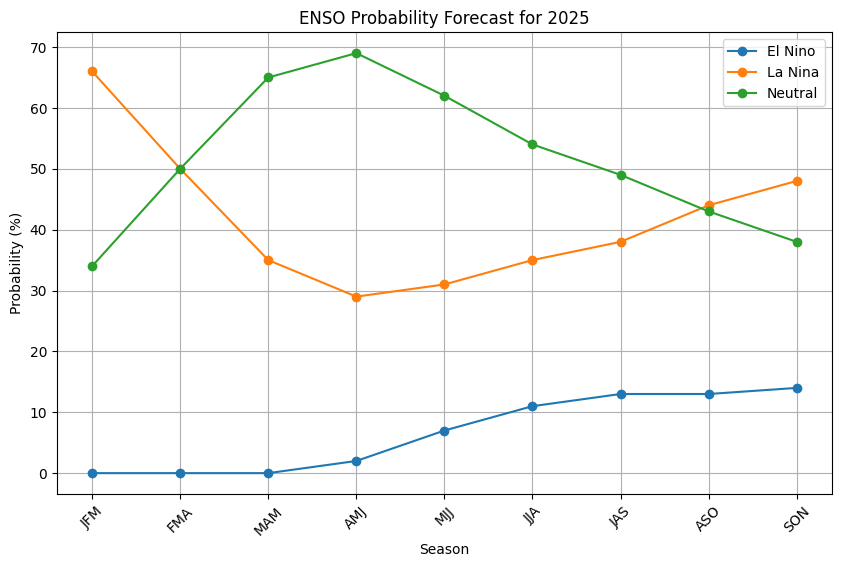

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON file
file_path = "data/enso_iri_prob.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Extract the 2025 predictions
year_2025 = next((year for year in data["years"] if year["year"] == 2025), None)

if year_2025:
    # Prepare a DataFrame
    records = []
    for month_data in year_2025["months"]:
        month = month_data["month"]
        for prob in month_data["probabilities"]:
            records.append({
                "Month": month,
                "Season": prob["season"],
                "El Nino": prob["elnino"],
                "La Nina": prob["lanina"],
                "Neutral": prob["neutral"]
            })
    
    df_2025 = pd.DataFrame(records)

    # Plot the probabilities for 2025
    plt.figure(figsize=(10, 6))
    for event in ["El Nino", "La Nina", "Neutral"]:
        plt.plot(df_2025["Season"], df_2025[event], marker="o", label=event)

    plt.xlabel("Season")
    plt.ylabel("Probability (%)")
    plt.title("ENSO Probability Forecast for 2025")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data found for the year 2025 in the provided JSON file.")


In [8]:
import plotly.graph_objects as go

# Create an interactive plot using Plotly
fig = go.Figure()

# Add traces for each ENSO condition
fig.add_trace(go.Scatter(x=df_2025["Season"], y=df_2025["El Nino"], mode='lines+markers', 
                         name="El Niño", line=dict(color='red')))

fig.add_trace(go.Scatter(x=df_2025["Season"], y=df_2025["La Nina"], mode='lines+markers', 
                         name="La Niña", line=dict(color='blue')))

fig.add_trace(go.Scatter(x=df_2025["Season"], y=df_2025["Neutral"], mode='lines+markers', 
                         name="Neutral", line=dict(color='black')))

# Update layout to remove background and grid
fig.update_layout(
    title="ENSO Probability Forecast for 2025",
    xaxis_title="Season",
    yaxis_title="Probability (%)",
    template="simple_white",  # Removes grid and background
    showlegend=True
)

# Show the interactive plot
fig.show()


In [6]:
import pickle
with open("outcome/frequency_12c_precip.pkl", "rb") as file:
    precip_res = pickle.load(file)

with open("outcome/lon_lat_idx_era5_12c.pkl", "rb") as file:
    points_idx_climate = pickle.load(file)

In [29]:
np.array(points_idx_climate['Brazil'])[:,0][: 40000]

array([ 848,  848,  848, ..., 1008, 1008, 1008])

In [87]:
np.nanmean(np.array(precip_res['Brazil'])[: 20000][:, 0, 11, 2])

0.22590267925808102

In [79]:
np.shape(np.array(precip_res['Brazil']))

(70741, 3, 12, 3)

In [88]:
np.nanmean(np.array(precip_res['Brazil'])[70000:][:, 0, 11, 2])

0.4342436974789915

In [52]:
above: 0.41625

In [ ]:
0.355